In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

(1000, 2) (1000,)


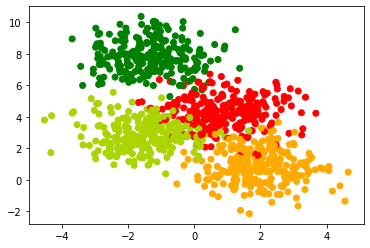

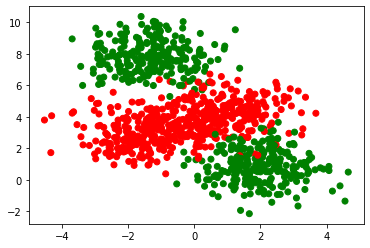

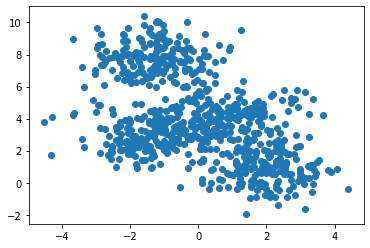

(750, 2) (250, 2)


In [63]:
#creating my own color map for better visualization
my_cmap = colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

#Generating 1000 observations with 4 labels - multi class
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

#visualize the data
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

#converting the multi-class to binary 
labels_orig = labels
labels = np.mod(labels_orig, 2)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

#split the binary data
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(Y_train)
plt.show()
print(X_train.shape, X_val.shape)

(750,) (250,)


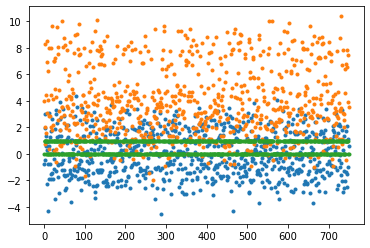

In [64]:
print(shape(Y_train),shape(Y_val))
plot(X_train[:,0],'.')
plot(X_train[:,1],'.')
plot(Y_train[:],'.')


In [3]:
class SigmoidNeuron:
  #intialization
  def __init__(self):
    self.w = None
    self.b = None
  #forward pass  
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  #updating the gradients using mean squared error loss
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  #updating the gradients using cross entropy loss
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  #model fit method
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
          
      m = X.shape[1]  
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [40]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):
    #intialize the inputs
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    print(shape(x))
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=True):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
      print((loss))
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
        
    if display_loss:
      val = np.zeros(len(loss))
      s = loss.values()
      i = 0
      for point in s:
            val[i] = point
            i = i+1
      plt.plot(val)
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

In [41]:
#train the network with two hidden layers - 2 neurons and 3 neurons
ffsnn = FFSNNetwork(2, [2, 3])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.002, display_loss=True)

Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

#visualize the results
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

{}


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


KeyboardInterrupt: 

In [8]:
# x = {}
# x = {0:234,1:254,2:124}
# y = []
# z = ()
# print(type(x),type(y),type(z))
# s = x.values()
# x = np.zeros(len(x))
# i = 0
# for g in s:
#     x[i] = g
#     i = i+1
    
# plt.plot(x)
# # print(float[v for v in s][0])
# # print(x.values(),x.items())

In [9]:
# folder_loc = 'Albert_Data/Run 1/'
# file_loc = '2020-02-28-17-01_JG_DL_Run1_001.dat'
# dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

# for filename in os.listdir(folder_loc):
#     if filename == file_loc:
#         pass
#     try:
#         tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
#         dat = np.concatenate((dat,tempdata))
#         print(filename,end='\r')
#     except:
#         print('ERROR: ',filename)

In [15]:



import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import matplotlib
import time
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
%pylab inline
# load data
file_name = "trx_2-"
folder_name = "Albert_Data/2019-02-26/"

# trx_2.npy is a numpy array compiled from a calibration measurement
dat=load(folder_name+"trx_2.npy")
geo=dat[:,0]
z=dat[:,1]

Populating the interactive namespace from numpy and matplotlib


In [19]:


# def __init__(self, xdata, ydata, dt1, zdata=None, optimize=True,
#              p=None,**kwarg):
#     self.dt1 = dt1
#     if p == None:
#         self.p = [len(xdata),0,0]
#     else:
#         self.p = p
#     [self.transf, self.freqs] = self.get_transf(xdata, ydata, self.p, dt1)
#     self.xdata = [xdata]
#     self.ydata = [ydata]
#     self.N = len(self.xdata)

def fit_cancel(array, n=2):
    t=np.linspace(0,len(array),len(array))
    fit = np.polyfit(t,array,n)
    corrective = fit[n]*np.ones(np.shape(t))
    for j in np.arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

# x is the array, n is the length of each segment, o is the number of overlaping elements adjacent segments share
def chop(x,n,o):
    segs = np.zeros(((len(x)-o)//(n-o),n),dtype=np.complex)
    j = 0
    while len(x) >= n:
#             i = 0
#             mini_seg = np.zeros(n)
#             while i < n:
#                 mini_seg[i] = x[i]
#                 i+=1
#             segs[j,:] = mini_seg
        segs[j,:] = fit_cancel(x[:n])
        j+=1
        x=x[n-o:]
#             x = x[i-o:]
    return segs

# Applies a Kaiser Window paramaterized by b to each segment
def window(segs,b):
    seg_num = len(segs[:,0])
    seg_leng = len(segs[0,:])
    for i in range(0,seg_num):
        segs[i,:] = segs[i,:]*np.kaiser((seg_leng),b)
    return segs

# Fourier Transforms each Row, given time between samples, dt
def fourier(segs,dt):
    seg_num = len(segs[:,0])
    freqs = np.fft.fftfreq(len(segs[0,:]),dt)
    for i in range(0,seg_num):
        segs[i,:] = np.fft.fft(segs[i,:])
    return freqs,segs

def get_transf(xdata, ydata, p, dt):

    n = int(p[0])
    o = int(p[1])
    b = p[2]

    top = chop(ydata,n,o)
    top = window(top,b)
    [freqs, ftop] = fourier(top,dt)

    bottom = chop(xdata,n,o)
    bottom = window(bottom,b)
    [freqs, fbottom] = fourier(bottom,dt)
    
    return ftop,fbottom,freqs

#     num_segs = len(fbottom[:,0])
#     numer = 0
#     denomer = 0
#     for i in range(0,num_segs):
#         numer += ftop[i,:]*np.conjugate(fbottom[i,:])
#         denomer += fbottom[i,:]*np.conjugate(fbottom[i,:])

#     numer = numer/num_segs
#     denomer = denomer/num_segs

#     tf = numer/denomer
#     tf_spl = interp1d(freqs, tf)
#     return tf_spl,freqs

In [35]:
tip_ft, geo_ft, freqs = get_transf(geo[:100000],z[:100000],[20000,12500,5],1/10000)
tip_ft = tip_ft.T
geo_ft = geo_ft.T

In [36]:
print(shape(tip_ft),shape(geo_ft),shape(freqs))
print(shape(X_train),shape(Y_train))

(20000, 11) (20000, 11) (20000,)
(750, 2) (750,)


In [38]:
ffsnn = FFSNNetwork(0, [len(freqs), len(freqs)])

In [42]:
#train the network with 0 hidden layers - len(fft) neurons and len(fft) neurons

geo_train = geo_ft
tip_train = tip_ft
ffsnn.fit(geo_ft,tip_train,epochs=1, learning_rate=0.2,display_loss=True)
# ffsnn.fit(X_train, Y_train, epochs=1, learning_rate=.2, display_loss=True)

# Y_pred_train = ffsnn.predict(X_train)
# Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
# Y_pred_val = ffsnn.predict(X_val)
# Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
# accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
# accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

# print("Training accuracy", round(accuracy_train, 2))
# print("Validation accuracy", round(accuracy_val, 2))

#visualize the results
# plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
# plt.show()

{}


(11,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 11)

In [34]:
x = linspace(0,9,10)
y = linspace(13,22,10)
x = x.reshape(2,5)
y = y.reshape(2,5)
print(x.T)
print(y)
for x1,y1 in zip(x,y):
    print(x1,y1)

[[0. 5.]
 [1. 6.]
 [2. 7.]
 [3. 8.]
 [4. 9.]]
[[13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22.]]
[0. 1. 2. 3. 4.] [13. 14. 15. 16. 17.]
[5. 6. 7. 8. 9.] [18. 19. 20. 21. 22.]


In [54]:
x = np.zeros((2,1))
print(x)
print(x.reshape(1,-1))

[[0.]
 [0.]]
[[0. 0.]]
